In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm  # Optional: for progress tracking
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling
from src.utils.visualization.core import create_standalone_colorbar, Lx, Ly, discretize_cmaps

In [2]:
def bootstrap_behavior_distribution(df, behavior_type, n_bootstrap=1000, random_state=None):
    """
    Perform bootstrap analysis on behavior distribution to estimate mean and polarization.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        n_bootstrap: Number of bootstrap samples to generate
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary containing:
        - 'bootstrap_means': List of mean values from each bootstrap sample
        - 'bootstrap_polarizations': List of polarization values (4*variance) from each bootstrap sample
        - 'mean_estimate': Average of bootstrap means
        - 'mean_ci': 95% confidence interval for the mean
        - 'polarization_estimate': Average of bootstrap polarizations
        - 'polarization_ci': 95% confidence interval for polarization
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get clean dataset with no NAs in the target behavior
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_samples = len(df_clean)
    
    # Arrays to store bootstrap results
    bootstrap_means = np.zeros(n_bootstrap)
    bootstrap_polarizations = np.zeros(n_bootstrap)
    
    # Perform bootstrap
    for i in tqdm(range(n_bootstrap), desc=f"Bootstrapping {behavior_type}"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_sample = df_clean.iloc[bootstrap_indices]
        
        # Get self-reported behavior and rescale from 1-5 to 0-1
        self_behavior = bootstrap_sample[f'{behavior_type}_self'].astype(int)
        rescaled_behavior = (self_behavior - 1) / 4  # Rescale from 1-5 to 0-1
        
        # Calculate mean and polarization for this bootstrap sample
        mean = np.mean(rescaled_behavior)
        variance = np.var(rescaled_behavior)
        polarization = 4 * variance  # Calculate polarization as requested
        
        # Store results
        bootstrap_means[i] = mean
        bootstrap_polarizations[i] = polarization
    
    # Calculate summary statistics
    mean_estimate = np.mean(bootstrap_means)
    polarization_estimate = np.mean(bootstrap_polarizations)
    
    # Calculate 95% confidence intervals
    mean_ci = np.percentile(bootstrap_means, [2.5, 97.5])
    polarization_ci = np.percentile(bootstrap_polarizations, [2.5, 97.5])
    
    return {
        'bootstrap_means': bootstrap_means,
        'bootstrap_polarizations': bootstrap_polarizations,
        'mean_estimate': mean_estimate,
        'mean_ci': mean_ci,
        'polarization_estimate': polarization_estimate,
        'polarization_ci': polarization_ci
    }

# Example usage:


In [3]:
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)
# drop the rows with missing values in the behavior columns
print(f"Number of rows before dropping NAs: {len(df)}")
df = df.dropna()

# print how many rows are left in the dataframe
print(f"Number of rows after dropping NAs: {len(df)}")

Number of rows before dropping NAs: 1612
Number of rows after dropping NAs: 1360


In [8]:
results_masks = bootstrap_behavior_distribution(df, "masks", n_bootstrap=50000)
print(f"[{np.round(results_masks['mean_ci'][0], 2)}, {np.round(results_masks['mean_estimate'], 2)}, {np.round(results_masks['mean_ci'][1], 2)}]")
print(f"[{np.round(results_masks['polarization_ci'][0], 2)}, {np.round(results_masks['polarization_estimate'], 2)}, {np.round(results_masks['polarization_ci'][1], 2)}]")

results_testing = bootstrap_behavior_distribution(df, "testing", n_bootstrap=50000)
print(f"[{np.round(results_testing['mean_ci'][0], 2)}, {np.round(results_testing['mean_estimate'], 2)}, {np.round(results_testing['mean_ci'][1], 2)}]")
print(f"[{np.round(results_testing['polarization_ci'][0], 2)}, {np.round(results_testing['polarization_estimate'], 2)}, {np.round(results_testing['polarization_ci'][1], 2)}]")

results_vacc = bootstrap_behavior_distribution(df, "vacc", n_bootstrap=50000)
print(f"[{np.round(results_vacc['mean_ci'][0], 2)}, {np.round(results_vacc['mean_estimate'], 2)}, {np.round(results_vacc['mean_ci'][1], 2)}]")
print(f"[{np.round(results_vacc['polarization_ci'][0], 2)}, {np.round(results_vacc['polarization_estimate'], 2)}, {np.round(results_vacc['polarization_ci'][1], 2)}]")


Bootstrapping masks: 100%|██████████| 50000/50000 [01:42<00:00, 486.42it/s] 


[0.76, 0.77, 0.79]
[0.25, 0.28, 0.3]


Bootstrapping testing: 100%|██████████| 50000/50000 [02:43<00:00, 306.14it/s]


[0.45, 0.47, 0.49]
[0.46, 0.48, 0.5]


Bootstrapping vacc: 100%|██████████| 50000/50000 [03:18<00:00, 251.60it/s] 

[0.59, 0.61, 0.63]
[0.55, 0.57, 0.6]


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

def visualize_histogram(bootstrap_results, behavior_types, figsize=(16, 12)):
    """
    Create histograms to visualize bootstrap distributions of mean and polarization.
    
    Args:
        bootstrap_results: Dictionary with keys as behavior types and values as results from bootstrap_behavior_distribution
        behavior_types: List of behavior types to include (e.g., ["masks", "testing", "vacc"])
        figsize: Tuple specifying figure dimensions
    
    Returns:
        matplotlib figure
    """
    fig, axes = plt.subplots(2, len(behavior_types), figsize=figsize)
    
    # Create a single row if only one behavior type
    if len(behavior_types) == 1:
        axes = axes.reshape(-1, 1)
    
    # Set up plot parameters
    cmap = "viridis"
    bins = 25
    
    for i, behavior in enumerate(behavior_types):
        results = bootstrap_results[behavior]
        
        # Get bootstrap data
        means = results['bootstrap_means']
        polarizations = results['bootstrap_polarizations']
        
        # Create 2D histogram for joint distribution
        hist_data, x_edges, y_edges = np.histogram2d(
            means, 
            polarizations, 
            bins=bins
        )
        
        # Plot mean distribution (top row)
        sns.histplot(means, kde=True, color="blue", ax=axes[0, i])
        axes[0, i].axvline(results['mean_estimate'], color='red', linestyle='--')
        axes[0, i].axvline(results['mean_ci'][0], color='red', linestyle=':')
        axes[0, i].axvline(results['mean_ci'][1], color='red', linestyle=':')
        axes[0, i].set_title(f"{behavior.capitalize()} - Mean Distribution")
        axes[0, i].set_xlabel("Mean (0-1 scale)")
        axes[0, i].set_xlim(0.4, 0.8)
        
        # Plot polarization distribution (bottom row)
        sns.histplot(polarizations, kde=True, color="green", ax=axes[1, i])
        axes[1, i].axvline(results['polarization_estimate'], color='red', linestyle='--')
        axes[1, i].axvline(results['polarization_ci'][0], color='red', linestyle=':')
        axes[1, i].axvline(results['polarization_ci'][1], color='red', linestyle=':')
        axes[1, i].set_title(f"{behavior.capitalize()} - Polarization Distribution")
        axes[1, i].set_xlabel("Polarization (4 × variance)")
        axes[1, i].set_xlim(0.2, 0.7)
    
    plt.tight_layout()
    return fig

def visualize_bootstrap_joint(bootstrap_results, behavior_types, figsize=(18, 6)):
    """
    Create joint plot (2D heatmap) showing the relationship between mean and polarization.
    
    Args:
        bootstrap_results: Dictionary with keys as behavior types and values as results from bootstrap_behavior_distribution
        behavior_types: List of behavior types to include
        figsize: Tuple specifying figure dimensions
    
    Returns:
        matplotlib figure
    """
    fig, axes = plt.subplots(1, len(behavior_types), figsize=figsize)
    
    # Handle case with only one behavior type
    if len(behavior_types) == 1:
        axes = [axes]
    
    for i, behavior in enumerate(behavior_types):
        results = bootstrap_results[behavior]
        
        # Get bootstrap data
        means = results['bootstrap_means']
        polarizations = results['bootstrap_polarizations']
        
        # Create 2D histogram/heatmap
        hist2d = axes[i].hist2d(
            means, 
            polarizations, 
            bins=30, 
            cmap='viridis', 
            norm=LogNorm()  # Log scale for better visualization of density
        )
        
        # Mark the central estimate
        axes[i].scatter(
            [results['mean_estimate']], 
            [results['polarization_estimate']], 
            color='red', 
            marker='x', 
            s=100
        )
        
        # Add contour lines to show density
        H, xedges, yedges = np.histogram2d(means, polarizations, bins=30)
        X, Y = np.meshgrid((xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2)
        axes[i].contour(X, Y, H.T, levels=5, colors='white', alpha=0.5)
        
        # Configure axes
        axes[i].set_title(f"{behavior.capitalize()} Behavior")
        axes[i].set_xlabel("Mean (0-1 scale)")
        axes[i].set_ylabel("Polarization (4 × variance)")
    
    # Add colorbar with proper positioning
    fig.subplots_adjust(right=0.9)  # Make room for the colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(hist2d[3], cax=cbar_ax)
    cbar.set_label('Bootstrap Sample Count (log scale)')
    
    plt.tight_layout()
    # Adjust after tight_layout to maintain colorbar position
    fig.subplots_adjust(right=0.9)
    
    return fig

In [10]:
# Run bootstrap analysis for each behavior type
bootstrap_results = {
    "masks": results_masks,
    "testing": results_testing,
    "vacc": results_vacc
}

C:\Users\nel_t\AppData\Local\Temp\ipykernel_3872\1949974497.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


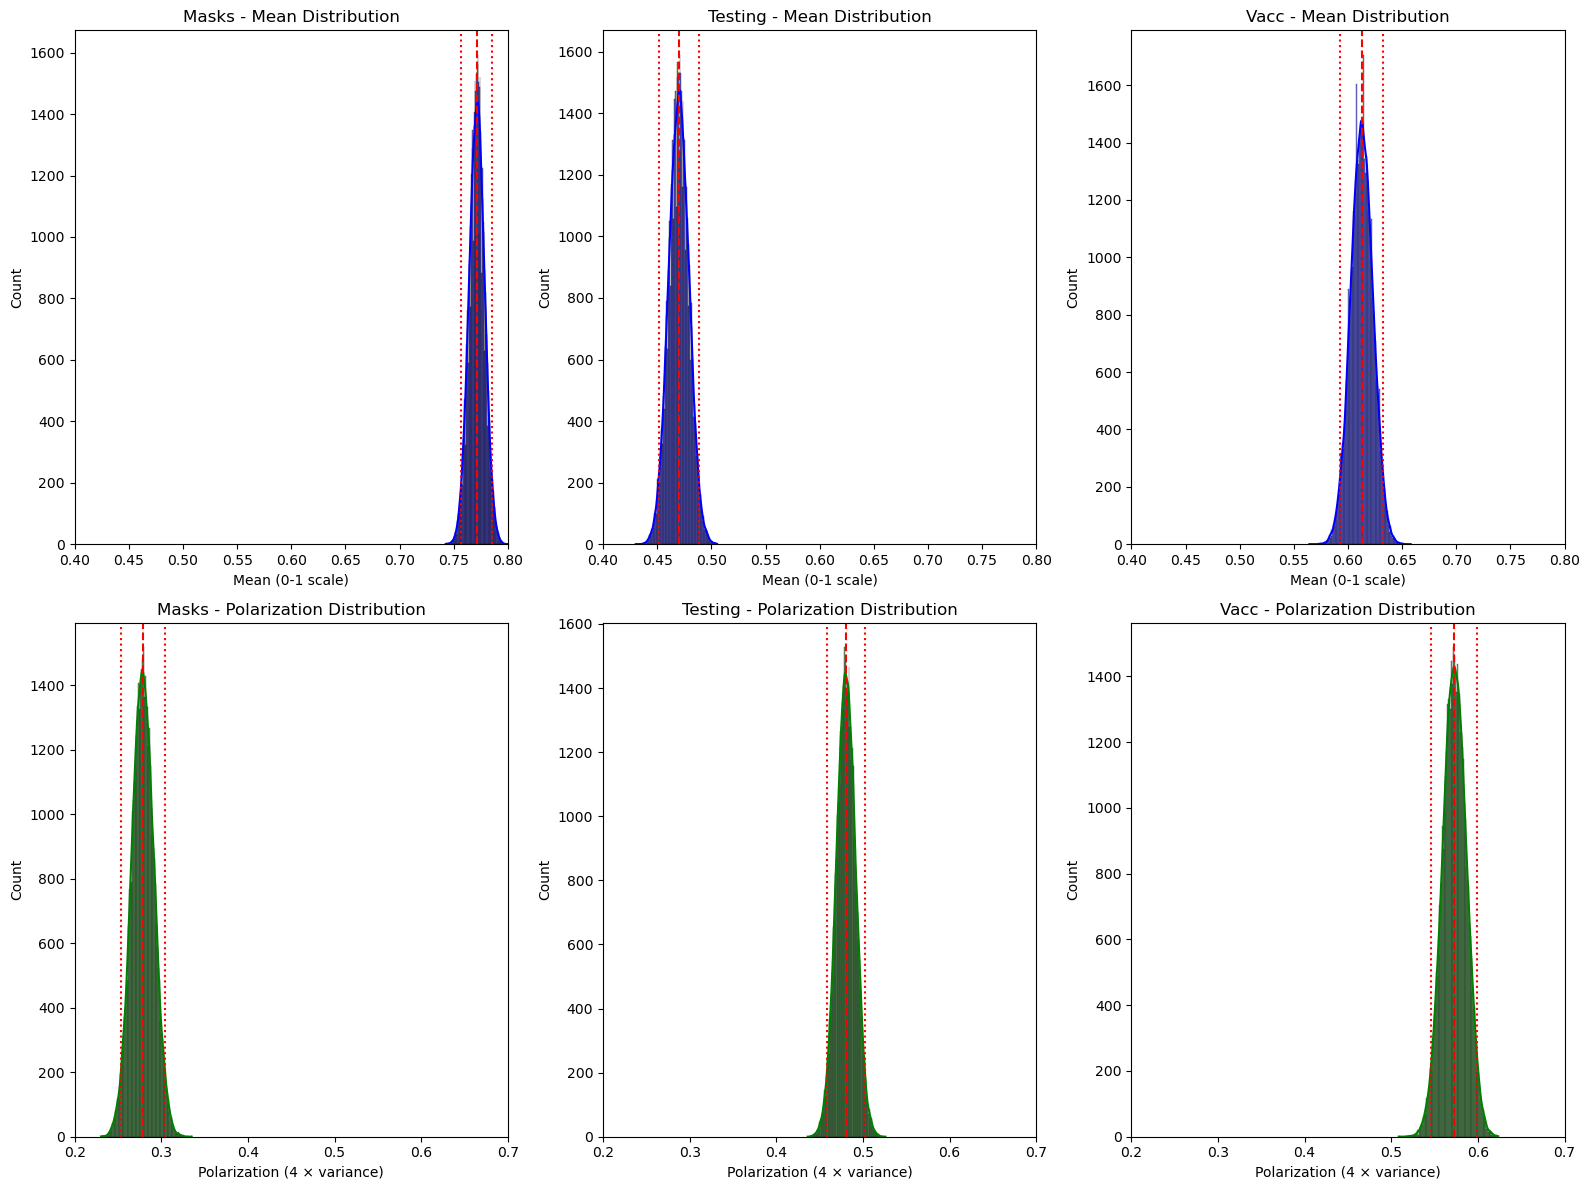

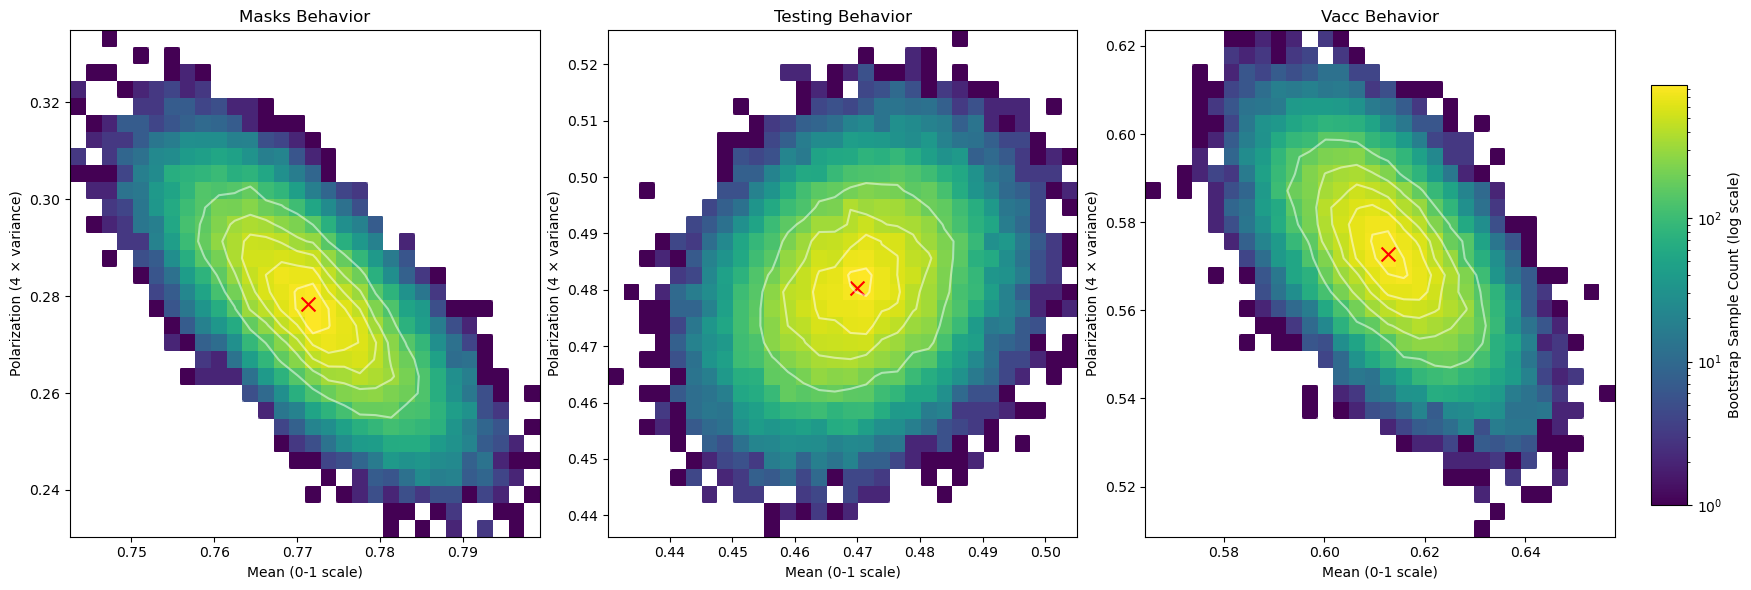

In [11]:
# Define behavior types to visualize
behavior_types = ["masks", "testing", "vacc"]

# Create histograms of bootstrap distributions with confidence intervals
fig1 = visualize_histogram(bootstrap_results, behavior_types)

# Create 2D heatmaps showing joint distribution of mean and polarization
fig2 = visualize_bootstrap_joint(bootstrap_results, behavior_types)

# Display the visualizations
plt.show()

In [12]:
def generate_raw_matrix(df, behavior_type = "masks"):
    """
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
    Returns:
        Raw contact matrix
    """
    n_bins = 5
    
    # Clean data
#    df_clean = df.dropna()
    
    # Generate raw contact matrix
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Define columns based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Fill contact matrix
    for i, row in df.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    return contact_matrix




def extract_behavior_distribution(df, behavior_type):
    """
    Extract behavior distribution from raw CSV data.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Normalized behavior distribution as a numpy array
    """
    # Clean data
    df = df.dropna()
    
    # Extract self-reported behavior
    self_behavior = df[f'{behavior_type}_self'].astype(int)
    
    # Count occurrences of each behavior level (1-5)
    n_bins = 5
    behavior_vector = np.zeros(n_bins)
    for i in range(n_bins):
        behavior_vector[i] = np.sum(self_behavior == i+1)
    
    # Normalize to get distribution
    behavior_vector = behavior_vector / np.sum(behavior_vector)
    
    return behavior_vector

def normalize_by_row(M):
    return M / np.sum(M, axis=1, keepdims=True)

def generate_normalized_matrix(df, behavior_type = "masks"):
    """
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
    Returns:
        Normalized contact matrix
    """
    # Extract behavior distribution
    
    # Generate raw contact matrix
    raw_matrix = generate_raw_matrix(df, behavior_type)
    
    normalized_matrix = normalize_by_row(raw_matrix)

    return normalized_matrix


def metric (M0, M1, name = "L2"):

    if(name == "L2"):
        
        # Ensure matrices are numpy arrays
        a = np.array(M0)
        b = np.array(M1)
        
        # Calculate the difference
        diff = a - b
        
        return np.sqrt(np.sum(diff * diff))
        #return np.mean(diff * diff)
    
    else:
        raise ValueError(f"Unknown metric: {name}")



def homophily_estimation(df, h_min = 1, h_max = 3, behavior_type = "masks"):
    """
    Estimate homophily based on behavior distribution and contact matrix.
    
    Args:
        df: DataFrame with survey data
        h_min: Minimum value for homophily
        h_max: Maximum value for homophily
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Homophily estimate as a float
    """
    # Extract behavior distribution
    
    # Generate normalized contact matrix
    normalized_matrix = generate_normalized_matrix(df, behavior_type)
    
    n_bins = len(normalized_matrix)


    N_H_bins = 101
    Diffs_Sinkhorn = np.zeros(N_H_bins)
    list_h = np.linspace(h_min, h_max, N_H_bins)
    for i, h in enumerate(list_h):
        CS = create_contact_matrix(n_bins, h)
        Diffs_Sinkhorn[i] = metric(CS/5, normalized_matrix)

    homophily = list_h[np.argmin(Diffs_Sinkhorn[:])]
    
    return homophily

In [13]:
print("Homophily estimation for masks:", homophily_estimation(df,  behavior_type = "masks"))
print("Homophily estimation for testing:", homophily_estimation(df,  behavior_type = "testing"))
print("Homophily estimation for vaccination:", homophily_estimation(df, behavior_type = "vacc"))

TypeError: create_contact_matrix() missing 1 required positional argument: 'group_sizes'

In [ ]:
indices = np.arange(0, len(df))


# precalculate the contribution to the contact matrix of each individual

CMC = np.zeros((len(df), 5, 5, 3))
for i in tqdm(range(len(df))):
    CMC[i,:,:,0] = generate_raw_matrix_single_agent(df, i, behavior_type = "masks")
    CMC[i,:,:,1] = generate_raw_matrix_single_agent(df, i, behavior_type = "testing")
    CMC[i,:,:,2] = generate_raw_matrix_single_agent(df, i, behavior_type = "vacc")


# precalculate the synthetic contact matrices for homophily values between h_min and h_max, and N_h of them

h_min = 1
h_max = 4
N_h = 100






N_iteration = 10000
Hm = np.zeros(N_iteration)
Ht = np.zeros(N_iteration)
Hv = np.zeros(N_iteration)
for i in tqdm(range(N_iteration)):
    # Sample indices with replacement
    sampled_indices = np.random.choice(indices, size=750, replace=True)

    # Create sampled contact matrix
    sampled_CMC_M = normalize_by_row(np.sum(CMC[sampled_indices, :, :,0], axis=0))
    sampled_CMC_T = normalize_by_row(np.sum(CMC[sampled_indices, :, :,1], axis=0))
    sampled_CMC_V = normalize_by_row(np.sum(CMC[sampled_indices, :, :,2], axis=0))

    DIFFs = np.zeros((N_h, 3))
    for j in range(N_h):
        DIFFs[j, 0] = metric(sampled_CMC_M, CM_H[j, :, :])
        DIFFs[j, 1] = metric(sampled_CMC_T, CM_H[j, :, :])
        DIFFs[j, 2] = metric(sampled_CMC_V, CM_H[j, :, :])
    

    Hm[i] = h_list[np.argmin(DIFFs[:,0])]
    Ht[i] = h_list[np.argmin(DIFFs[:,1])]
    Hv[i] = h_list[np.argmin(DIFFs[:,2])]




In [ ]:
# calculate mean, std, median, and 95% confidence interval for each behavior type

def calculate_statistics(data):
    """
    Calculate mean, standard deviation, median, and 95% confidence interval.
    
    Args:
        data: numpy array of bootstrap results
        
    Returns:
        Dictionary with mean, std, median, and confidence interval
    """
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    ci = np.percentile(data, [2.5, 97.5])
    
    return {
        'mean': mean,
        'std': std,
        'median': median,
        'ci': ci
    }

statistics_masks = calculate_statistics(Hm)
statistics_testing = calculate_statistics(Ht)
statistics_vacc = calculate_statistics(Hv)

print("Masks statistics:")
print(f"Mean: {statistics_masks['mean']:.4f}, Std: {statistics_masks['std']:.4f}, Median: {statistics_masks['median']:.4f}, 95% CI: [{statistics_masks['ci'][0]:.4f}, {statistics_masks['ci'][1]:.4f}]")
print("Testing statistics:")
print(f"Mean: {statistics_testing['mean']:.4f}, Std: {statistics_testing['std']:.4f}, Median: {statistics_testing['median']:.4f}, 95% CI: [{statistics_testing['ci'][0]:.4f}, {statistics_testing['ci'][1]:.4f}]")
print("Vaccination statistics:")
print(f"Mean: {statistics_vacc['mean']:.4f}, Std: {statistics_vacc['std']:.4f}, Median: {statistics_vacc['median']:.4f}, 95% CI: [{statistics_vacc['ci'][0]:.4f}, {statistics_vacc['ci'][1]:.4f}]")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

def visualize_bootstrap_histograms(homophily_estimates, behavior_names=None, figsize=(15, 10),
                                  confidence_level=0.95, kde=True, bins=30, save_path=None):
    """
    Visualize histograms of bootstrap homophily estimates.
    
    Args:
        homophily_estimates: List or array of arrays containing bootstrap estimates
                            (e.g., [Hm, Ht, Hv])
        behavior_names: List of behavior names (e.g., ["Masks", "Testing", "Vaccination"])
        figsize: Figure size as (width, height)
        confidence_level: Confidence level for interval (default 0.95)
        kde: Whether to show kernel density estimate curve
        bins: Number of histogram bins
        save_path: Optional path to save the figure
    """
    if behavior_names is None:
        if len(homophily_estimates) == 3:
            behavior_names = ["Masks", "Testing", "Vaccination"]
        else:
            behavior_names = [f"Behavior {i+1}" for i in range(len(homophily_estimates))]
    
    # Set up the figure
    fig, axes = plt.subplots(len(homophily_estimates), 1, figsize=figsize)
    if len(homophily_estimates) == 1:
        axes = [axes]
    
    # Colors
    histogram_color = 'skyblue'
    kde_color = 'darkblue'
    mean_color = 'red'
    median_color = 'purple'
    ci_color = 'green'
    
    alpha = 1 - confidence_level
    
    for i, (estimates, name) in enumerate(zip(homophily_estimates, behavior_names)):
        ax = axes[i]
        
        # Calculate statistics
        mean_h = np.mean(estimates)
        median_h = np.median(estimates)
        std_h = np.std(estimates, ddof=1)
        ci_lower = np.percentile(estimates, alpha/2 * 100)
        ci_upper = np.percentile(estimates, (1-alpha/2) * 100)
        
        # Plot histogram
        ax.hist(estimates, bins=bins, alpha=0.7, color=histogram_color, 
                edgecolor='black', density=True)
        
        # Plot KDE if requested
        if kde:
            kde_est = stats.gaussian_kde(estimates)
            x = np.linspace(min(estimates), max(estimates), 1000)
            ax.plot(x, kde_est(x), color=kde_color, linewidth=2)
            
            # Fill confidence interval area
            x_fill = np.linspace(ci_lower, ci_upper, 1000)
            ax.fill_between(x_fill, 0, kde_est(x_fill), alpha=0.3, color=ci_color)
        
        # Add vertical lines
        ax.axvline(mean_h, color=mean_color, linestyle='-', linewidth=2, 
                   label=f'Mean: {mean_h:.3f}')
        ax.axvline(median_h, color=median_color, linestyle=':', linewidth=2, 
                   label=f'Median: {median_h:.3f}')
        ax.axvline(ci_lower, color=ci_color, linestyle='--', linewidth=2, 
                   label=f'{confidence_level*100:.1f}% CI: ({ci_lower:.3f}, {ci_upper:.3f})')
        ax.axvline(ci_upper, color=ci_color, linestyle='--', linewidth=2)
        
        # Add labels and title
        ax.set_xlabel('Homophily Estimate (h)')
        ax.set_ylabel('Density')
        ax.set_title(f'Bootstrap Distribution for {name} Homophily')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes


def print_homophily_summary(homophily_estimates, behavior_names=None, confidence_level=0.95):
    """
    Print a summary of homophily bootstrap statistics.
    
    Args:
        homophily_estimates: List or array of arrays containing bootstrap estimates
                            (e.g., [Hm, Ht, Hv])
        behavior_names: List of behavior names (e.g., ["Masks", "Testing", "Vaccination"])
        confidence_level: Confidence level for interval (default 0.95)
        
    Returns:
        DataFrame with summary statistics
    """
    if behavior_names is None:
        if len(homophily_estimates) == 3:
            behavior_names = ["Masks", "Testing", "Vaccination"]
        else:
            behavior_names = [f"Behavior {i+1}" for i in range(len(homophily_estimates))]
    
    alpha = 1 - confidence_level
    
    # Create dataframe to store results
    results = {
        'Behavior': [],
        'Mean': [],
        'Median': [],
        'Std Error': [],
        f'{confidence_level*100:.1f}% CI Lower': [],
        f'{confidence_level*100:.1f}% CI Upper': [],
        'Min': [],
        'Max': []
    }
    
    # Calculate and print statistics for each behavior
    print(f"=== Homophily Estimation Summary ({confidence_level*100:.1f}% Confidence) ===")
    print("="*70)
    
    for estimates, name in zip(homophily_estimates, behavior_names):
        mean_h = np.mean(estimates)
        median_h = np.median(estimates)
        std_h = np.std(estimates, ddof=1)
        ci_lower = np.percentile(estimates, alpha/2 * 100)
        ci_upper = np.percentile(estimates, (1-alpha/2) * 100)
        min_h = np.min(estimates)
        max_h = np.max(estimates)
        
        print(f"Behavior: {name}")
        print(f"  Mean:                   {mean_h:.4f}")
        print(f"  Median:                 {median_h:.4f}")
        print(f"  Standard Error:         {std_h:.4f}")
        print(f"  {confidence_level*100:.1f}% CI:               ({ci_lower:.4f}, {ci_upper:.4f})")
        print(f"  Min/Max:                ({min_h:.4f}, {max_h:.4f})")
        print("-"*70)
        
        # Add to results dict
        results['Behavior'].append(name)
        results['Mean'].append(mean_h)
        results['Median'].append(median_h)
        results['Std Error'].append(std_h)
        results[f'{confidence_level*100:.1f}% CI Lower'].append(ci_lower)
        results[f'{confidence_level*100:.1f}% CI Upper'].append(ci_upper)
        results['Min'].append(min_h)
        results['Max'].append(max_h)
    
    # Create and return DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


def compare_homophily_behaviors(homophily_estimates, behavior_names=None, figsize=(10, 6),
                               confidence_level=0.95, violin=True, save_path=None):
    """
    Create a comparison visualization of homophily across different behaviors.
    
    Args:
        homophily_estimates: List or array of arrays containing bootstrap estimates
                            (e.g., [Hm, Ht, Hv])
        behavior_names: List of behavior names (e.g., ["Masks", "Testing", "Vaccination"])
        figsize: Figure size as (width, height)
        confidence_level: Confidence level for interval (default 0.95)
        violin: Whether to show violin plots (otherwise box plots)
        save_path: Optional path to save the figure
    """
    if behavior_names is None:
        if len(homophily_estimates) == 3:
            behavior_names = ["Masks", "Testing", "Vaccination"]
        else:
            behavior_names = [f"Behavior {i+1}" for i in range(len(homophily_estimates))]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert to DataFrame for easier plotting
    df_data = {name: estimates for name, estimates in zip(behavior_names, homophily_estimates)}
    df = pd.DataFrame(df_data)
    
    if violin:
        # Violin plot
        parts = ax.violinplot(homophily_estimates, showmeans=True, showmedians=True)
        
        # Customize violin appearance
        for pc in parts['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
        
        parts['cmeans'].set_color('red')
        parts['cmedians'].set_color('blue')
        parts['cmins'].set_color('gray')
        parts['cmaxes'].set_color('gray')
    else:
        # Box plot
        boxplot = ax.boxplot(homophily_estimates, patch_artist=True, showmeans=True)
        
        # Customize boxplot appearance
        for box in boxplot['boxes']:
            box.set(facecolor='skyblue', alpha=0.7)
        
        for median in boxplot['medians']:
            median.set(color='blue', linewidth=2)
            
        for mean in boxplot['means']:
            mean.set(color='red', linewidth=2)
    
    # Add labels and title
    ax.set_xticks(np.arange(1, len(behavior_names) + 1))
    ax.set_xticklabels(behavior_names)
    ax.set_ylabel('Homophily Estimate (h)')
    ax.set_title('Comparison of Homophily Across Behaviors')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add legend for mean and median
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Mean'),
        Line2D([0], [0], color='blue', lw=2, label='Median')
    ]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

In [15]:
summary_df = print_homophily_summary([Hm, Ht, Hv])

NameError: name 'Hm' is not defined

In [ ]:
visualize_bootstrap_histograms([Hm, Ht, Hv])

In [ ]:
compare_homophily_behaviors([Hm, Ht, Hv])

In [ ]:
def from_mm_to_inches(mm):
    """
    Convert millimeters to inches.
    
    Args:
        mm: Value in millimeters
        
    Returns:
        Value in inches
    """
    return mm / 25.4

In [ ]:
LX2 = from_mm_to_inches(87)
LY2 = from_mm_to_inches(235)



In [ ]:
def visualize_contact_matrix(matrix, title=None, cmap="Blues", Lx = LX2/2):
    """
    Visualize a contact matrix as a heatmap.
    
    Args:
        matrix: The contact matrix to visualize (numpy array)
        title: Optional title for the plot
        cmap: Colormap to use (default: "viridis")
        
    Returns:
        fig, ax: The matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(1,1, figsize=(Lx, Lx))
    im = ax.imshow(matrix, cmap=cmap, vmin =0, vmax=0.6)
    
    # Add colorbar
    #plt.colorbar(im)
    
    # Add title if provided
    if title:
        ax.set_title(title)
    
    # Add row and column labels
    label_list = ["1", "2", "3", "4", "5"]
    ax.set_xticks(np.arange(len(label_list)))
    ax.set_yticks(np.arange(len(label_list)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return fig, ax

In [ ]:
CM_M = generate_normalized_matrix(df, behavior_type="masks")
f,a = visualize_contact_matrix(CM_M)

f.savefig("figures/Fig_2/CM_M.pdf", dpi=300, bbox_inches='tight')


C_T = generate_normalized_matrix(df, behavior_type="testing")
f,a = visualize_contact_matrix(C_T)
f.savefig("figures/Fig_2/CM_T.pdf", dpi=300, bbox_inches='tight')

CM_V = generate_normalized_matrix(df, behavior_type="vacc")
f,a = visualize_contact_matrix(CM_V)
f.savefig("figures/Fig_2/CM_V.pdf", dpi=300, bbox_inches='tight')

In [ ]:
cbar_fig = create_standalone_colorbar(
    cmap_name='Blues',
    vmin=0,
    vmax=2,
    height=Ly*3,
    width=Ly/8*3,
    ticks=[0, 1, 2],
    ticklabels=[],
    save_path='figures/Fig_2/real_colorbar_contact_matrices.pdf'
)

In [ ]:
masks_distribution = extract_behavior_distribution(df, "masks")
testing_distribution = extract_behavior_distribution(df, "testing")
vacc_distribution = extract_behavior_distribution(df, "vacc")

In [ ]:
def plot_behavior_distribution_custom_colors(df, behavior_type, colors=None, figsize=(Lx/2, Ly/2), save_path=None):
    """
    Plot histogram of behavior distribution with custom colors for each bar.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        colors: List of 5 colors for each bar (if None, uses default colors)
        figsize: Figure size as (width, height)
        save_path: Path to save the figure (if None, figure is not saved)
        
    Returns:
        fig, ax: The matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Default colors if none provided
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Ensure we have exactly 5 colors
    if len(colors) != 5:
        raise ValueError("Must provide exactly 5 colors, one for each behavior level")
    
    # Get behavior distribution
    distribution = extract_behavior_distribution(df, behavior_type)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram with custom colors
    x = np.arange(1, 6)  # Categories 1-5
    for i in range(5):
        ax.bar(x[i], distribution[i], width=1.0, color=colors[i], edgecolor='black', linewidth=1)
    
    ax.set_ylim(0, 0.5)
    # Remove all axis elements
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([])
    ax.set_yticks([0,0.25,0.5])
    ax.set_yticklabels([])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    # remove top and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    # Set background to transparent
    fig.patch.set_alpha(0.0)
    fig.patch.set_visible(False)
    
    # Save figure if path is provided
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

In [ ]:
intensity_colors = ['#8E0152', '#DE77AE', '#F7F7F7', '#7FBC41', '#276419']

In [ ]:
plot_behavior_distribution_custom_colors(
    df, "masks", colors=intensity_colors, 
    save_path="figures/Fig_2/masks_distribution.pdf",
    figsize=(LX2/2, LX2/2.2)
)

plot_behavior_distribution_custom_colors(
    df, "testing", colors=intensity_colors, 
    save_path="figures/Fig_2/testing_distribution.pdf",
    figsize=(LX2/2, LX2/2.2)
)

plot_behavior_distribution_custom_colors(
    df, "vacc", colors=intensity_colors, 
    save_path="figures/Fig_2/vacc_distribution.pdf",
    figsize=(LX2/2, LX2/2.2)
)